In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import shutil 
import warnings
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import argparse
import torchvision
from torch.autograd import Variable
from tqdm import tqdm
import array
import matplotlib.pyplot as plt
from PIL import Image
# Ignore warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

path_to_ddsm = "/home/harsh/project/DDSM/"

In [2]:
#It is used to delete file with different different extension present in the directory once you convert the LJPEG 
#jpg format 
def delete_file_with_ext(cur_dir, old_ext, sub_dirs=False):
    if sub_dirs:
        for root, dirs, files in os.walk(cur_dir):
            for filename in files:
                file_ext = os.path.splitext(filename)[1]
                if old_ext == file_ext:
                    oldname = os.path.join(root, filename)
                    os.remove(oldname)
    else:
        os.remove(cur_dir)

In [3]:
for root, subFolders, file_names in os.walk(path_to_ddsm):
    for file_name in file_names:
        if ".LJPEG" in file_name:
            ljpeg_path = os.path.join(root, file_name)
            delete_path = os.path.join(root, file_name)
            #print(delete_path)
            out_path = delete_path.split('.LJPEG')[0] + ".jpg"
            
            cmd = './ljpeg.py "{0}" "{1}" --visual --scale 1.0'.format(ljpeg_path, out_path)
            os.system(cmd)
            delete_file_with_ext(delete_path, '.LJPEG', False)

print('done')

done


In [4]:
#It will delete files in all the folder of train and val
delete_file_with_ext(path_to_ddsm, '.OVERLAY', True)
delete_file_with_ext(path_to_ddsm, '.ics', True)
delete_file_with_ext(path_to_ddsm, '.16_PGM', True)

In [5]:
# class EncoderCNN(nn.Module):
#     def __init__(self):
#         super(EncoderCNN, self).__init__()
#         self.resnet = models.resnet18(pretrained=False)
#         #self.resnet.layer2 = nn.Sequential(*(self.resnet.layer2[i] for i in range(0)))
#     def forward(self, x1):
#         return self.resnet
            
# model_conv = EncoderCNN()

In [2]:
model_conv = models.resnet18(pretrained=False)

In [3]:
print (model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [8]:
# This function cut the images from the seqential folder of benigns, cancers and normal and paste it to the 
#parent directory i.e. benign, cancers and normal and then delete the sequential folder and then rename the images
#given in sequence, also it flips the LEFT image, so basically all are right after implementing this function
def check_word_type(filename):
    words = "LEFT"
    if words in filename: 
        return True
    
def flip_image(image_path, saved_location):
    """
    image_path: The path to the image to edit
    saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    rotated_image = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    rotated_image.save(saved_location)

def flip_cut_paste(paste_dir):
    for root, dirs, files in os.walk(paste_dir):
        for filename in files:
            #print(os.path.basename(filename))
            a = check_word_type(os.path.basename(filename))
            if a: 
                image = (os.path.join(root,os.path.basename(filename)))
                img = flip_image(image, image);
            shutil.move(os.path.join(root, os.path.basename(filename)), paste_dir)
    for root, dirs, files in os.walk(paste_dir):
        for directory in dirs:
            #print(directory)
            shutil.rmtree(os.path.join(root, directory))
    files = os.listdir(paste_dir)
    i = 1
    for file in files:
        os.rename(os.path.join(paste_dir, file), os.path.join(paste_dir, str(i)+'.jpg'))
        i = i+1


In [9]:
flip_cut_paste(os.path.join(path_to_ddsm, 'benigns'))
flip_cut_paste(os.path.join(path_to_ddsm, 'cancers'))
flip_cut_paste(os.path.join(path_to_ddsm, 'normal'))

In [10]:
train_dir = os.path.join(path_to_ddsm,'train')
train_benigns_dir = os.path.join(train_dir,'benigns')
train_cancers_dir = os.path.join(train_dir,'cancers')
train_normal_dir = os.path.join(train_dir,'normal')
val_dir = os.path.join(path_to_ddsm,'val')
val_benigns_dir = os.path.join(val_dir,'benigns') 
val_cancers_dir = os.path.join(val_dir,'cancers') 
val_normal_dir =  os.path.join(val_dir,'normal') 
os.makedirs(train_dir)
os.makedirs(train_benigns_dir)
os.makedirs(train_cancers_dir)
os.makedirs(train_normal_dir)
os.makedirs(val_dir)
os.makedirs(val_benigns_dir)
os.makedirs(val_cancers_dir)
os.makedirs(val_normal_dir)
no_image_val = 25
cut_paste = os.path.join(path_to_ddsm, 'benigns')
for root, dirs, files in os.walk(cut_paste):
    i = 0
    for filename in files:
        if i < no_image_val:
            shutil.move(os.path.join(cut_paste,os.path.basename(filename)),val_benigns_dir)
        else:
            shutil.move(os.path.join(cut_paste,os.path.basename(filename)),train_benigns_dir)
        i = i+1
shutil.rmtree(cut_paste)
cut_paste = os.path.join(path_to_ddsm, 'cancers')
for root, dirs, files in os.walk(cut_paste):
    i = 0
    for filename in files:
        if i < no_image_val:
            shutil.move(os.path.join(cut_paste,os.path.basename(filename)),val_cancers_dir)
        else:
            shutil.move(os.path.join(cut_paste,os.path.basename(filename)),train_cancers_dir)
        i = i+1
shutil.rmtree(cut_paste)
cut_paste = os.path.join(path_to_ddsm, 'normal')
for root, dirs, files in os.walk(cut_paste):
    i = 0
    for filename in files:
        if i < no_image_val:
            shutil.move(os.path.join(cut_paste,os.path.basename(filename)),val_normal_dir)
        else:
            shutil.move(os.path.join(cut_paste,os.path.basename(filename)),train_normal_dir)
        i = i+1
shutil.rmtree(cut_paste)

In [4]:
# to change the out feature of the model to 3
num_ftrs = model_conv.fc.in_features   #for resnet18
# num_ftrs = model_conv.classifier._modules['6'].in_features    #for VGG16_BN
print (num_ftrs)
# model_conv.classifier._modules['6'] = nn.Linear(num_ftrs, 3)    #for VGG16_BN
model_conv.fc = nn.Linear(num_ftrs, 3)     #for resnet18
print ("the value of output is", model_conv.fc.out_features)       #for resnet18   
# print ("The value of output is ",model_conv.classifier._modules['6'].out_features)        #for VGG16_BN


512
the value of output is 3


In [5]:
data_dir = path_to_ddsm
input_shape = 224
batch_size = 64
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
scale = (224,224)
use_parallel = True
use_gpu = False
epochs = 1
data_transforms = {
        'train': transforms.Compose([
        transforms.Resize(scale),
        transforms.RandomResizedCrop(input_shape),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
        'val': transforms.Compose([
        transforms.Resize(scale),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),}

print(data_transforms)

{'train': Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
), 'val': Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)}


In [10]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, use_gpu, num_epochs=25, mixup = False, alpha = 0.1):
    print("MIXUP".format(mixup))
    since = time.time()
    global l
    global e 
    global a 
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                #augementation using mixup
                if phase == 'train' and mixup:
                    inputs = mixup_batch(inputs, alpha)
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs, requires_grad = True), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                if type(outputs) == tuple:
                    outputs, _ = outputs
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                print("output is ",outputs)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    print("Before")
                    b = inputs.detach().numpy()
                    #plt.imshow(b[1,1,:,:])
                    #plt.show()
                    print(inputs.grad)
                    inputs = inputs - inputs.grad
                    
                    inputs = inputs.detach().numpy()
                    print("The backward prop is",inputs.shape)
                    #plt.imshow(inputs[1,1,:,:])
                    #plt.show()
                    #print("The backward prop is",inputs.grad.size())
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            #print("the running loss is")
            #print(running_loss)
            #print("the running corrects is")
            #print(running_corrects)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / float(dataset_sizes[phase])
            #print(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            lo = '{:4f}'.format(epoch_loss)
            ac = '{:4f}'.format(epoch_acc)
            if phase == 'train':
                #print("the value of a is")
                #print(a)
                l.append(float(lo))
            if phase == 'val':
                a.append(float(ac))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
                
        print()

    time_elapsed = time.time() - since
    i = 0
    for i in range(num_epochs):
        e.append(float(i))
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


  0%|          | 0/6 [00:00<?, ?it/s]

{'train': Dataset ImageFolder
    Number of datapoints: 365
    Root Location: /home/harsh/project/DDSM/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomVerticalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 75
    Root Location: /home/harsh/project/DDSM/val
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[

 17%|█▋        | 1/6 [00:29<02:26, 29.24s/it]

tensor([[[[ 1.0111e-05,  5.7923e-05, -2.3368e-05,  ...,  2.2223e-06,
            1.3827e-06, -4.9482e-06],
          [-4.9062e-06, -8.2145e-06, -1.2130e-05,  ...,  3.3657e-05,
           -2.9064e-06,  1.1356e-05],
          [ 3.4184e-06, -1.1519e-04, -9.6877e-05,  ...,  1.0853e-05,
           -1.6371e-05, -3.2784e-06],
          ...,
          [-1.4458e-05,  8.6341e-06,  6.3075e-06,  ...,  8.8413e-06,
           -2.9580e-06,  1.4090e-05],
          [ 1.0905e-06, -3.6175e-07, -8.3722e-06,  ..., -9.6657e-06,
           -5.1554e-07, -2.0417e-05],
          [-2.1203e-05, -2.5934e-06,  3.4685e-06,  ..., -1.7522e-05,
            2.9736e-06,  1.3633e-05]],

         [[-3.6654e-05,  1.3863e-05, -2.6590e-06,  ..., -2.4167e-05,
            1.4961e-05, -3.8644e-06],
          [ 9.6181e-06, -4.8878e-05,  2.2572e-05,  ...,  6.1567e-05,
            1.4350e-05,  2.1948e-05],
          [ 6.7547e-05,  5.4204e-05,  8.7629e-05,  ...,  1.6413e-05,
            6.7086e-06, -1.0157e-05],
          ...,
     

output is  tensor([[-0.7787, -0.3723,  0.6040],
        [-0.7860, -0.4680,  0.7424],
        [-0.8173, -0.4991,  0.4176],
        [-0.7520, -0.3517,  0.2964],
        [-0.8203, -0.4701,  0.8110],
        [-0.7663, -0.1166, -0.5148],
        [-0.8472,  0.1477, -1.4995],
        [-0.8645, -0.3900,  0.6417],
        [-0.7303, -0.6962, -1.6436],
        [-0.9654, -0.0560, -1.1882],
        [-0.7176, -0.0824, -1.7716],
        [-0.8739, -0.2917,  0.4854],
        [-0.7075, -0.1403, -1.3796],
        [-0.8388, -0.4301,  0.7161],
        [-0.6696,  0.3192, -0.6718],
        [-0.8102, -0.4216,  0.6776],
        [-0.9076, -0.4041,  0.7038],
        [-0.8606, -0.4969,  0.7576],
        [-0.7560,  0.2624, -0.5750],
        [-0.8329, -0.4726,  0.7656],
        [-1.1166,  0.0966, -1.6675],
        [-1.2458, -0.3682, -0.5196],
        [-0.8010, -0.4140,  0.6262],
        [-0.7936, -0.4151,  0.6757],
        [-0.8322, -0.3700,  0.5678],
        [-0.8455, -0.2814,  0.0139],
        [-1.1238, -0.0048, 

 33%|███▎      | 2/6 [00:40<01:20, 20.03s/it]

tensor([[[[-4.3153e-05, -3.2738e-05,  1.0015e-05,  ...,  2.2390e-07,
            4.0689e-06,  3.8777e-07],
          [ 2.1011e-05,  3.9165e-07,  5.4842e-07,  ...,  3.3563e-06,
           -1.0637e-05,  9.2059e-06],
          [-2.7100e-05, -3.9189e-05,  5.8399e-05,  ...,  2.0881e-05,
           -1.5159e-05,  2.0757e-06],
          ...,
          [-1.3945e-05,  3.1184e-05,  3.3684e-06,  ...,  1.8135e-06,
            2.2729e-06,  6.0540e-06],
          [ 8.8540e-06, -5.9926e-07,  5.3324e-06,  ..., -7.2572e-07,
           -8.0666e-07,  7.7214e-08],
          [-1.6155e-05, -1.2024e-06,  6.3242e-06,  ...,  2.2380e-06,
           -1.1506e-06,  2.4472e-07]],

         [[-1.4334e-05,  1.1336e-05, -1.0242e-05,  ..., -1.0012e-05,
           -2.0236e-06,  7.1347e-06],
          [-1.1577e-05,  3.5620e-05, -4.9305e-05,  ...,  1.4826e-05,
            9.1691e-06,  2.4267e-05],
          [ 4.9131e-06,  1.3486e-05, -1.7431e-05,  ...,  1.5932e-05,
           -9.9242e-06, -1.0235e-05],
          ...,
     

output is  tensor([[-0.8043, -0.2865,  0.5995],
        [-1.2436, -0.0277, -2.1219],
        [-0.8414, -0.4809,  0.7049],
        [-0.8394, -0.4233,  0.6062],
        [ 0.1544,  0.0664, -2.6219],
        [-0.8206, -0.3176,  0.5032],
        [-1.0845, -0.2744, -0.0306],
        [-0.9296, -0.3538,  0.3125],
        [-0.7539, -0.1172, -0.3294],
        [-0.7725, -0.2603,  0.4693],
        [-1.1230,  0.3906, -2.7771],
        [-0.9391, -0.5141,  0.6868],
        [-0.7631, -0.1788,  0.4286],
        [-0.3178, -0.5015, -3.9092],
        [-0.7812,  0.8267, -1.8496],
        [-0.7997, -0.2146,  0.3496],
        [-1.4500,  0.0427, -1.8094],
        [-0.7829,  0.1519, -1.4680],
        [-0.8422, -0.4854,  0.7882],
        [-0.7188,  0.2868, -1.9587],
        [-0.7922, -0.2944,  0.6193],
        [-0.8249, -0.4993,  0.7722],
        [-0.5387, -0.0028, -1.8714],
        [-1.1014,  0.2048, -1.8899],
        [-0.8038, -0.3568,  0.5228],
        [-0.8586, -0.5035,  0.6849],
        [-1.0422,  0.1207, 

 50%|█████     | 3/6 [00:50<00:50, 16.92s/it]

tensor([[[[ 3.8142e-05,  1.9414e-05,  3.4108e-06,  ..., -2.0841e-06,
           -4.2544e-06, -8.3137e-06],
          [-9.0379e-06,  2.0413e-05, -1.7388e-05,  ...,  4.3430e-06,
           -7.7653e-06,  4.8157e-06],
          [ 4.6738e-05, -3.2780e-05, -1.0388e-05,  ...,  1.1877e-05,
            6.0857e-06, -1.5340e-05],
          ...,
          [ 5.7688e-06,  5.9133e-06,  1.0087e-05,  ..., -2.3585e-06,
            3.2244e-06,  4.7378e-06],
          [-3.7484e-06, -8.1348e-06, -7.1021e-06,  ..., -2.0210e-06,
           -4.0833e-06,  1.8767e-06],
          [-3.3380e-06,  6.1174e-06, -7.8127e-07,  ..., -3.2182e-06,
            1.7365e-06,  2.6361e-07]],

         [[ 2.9551e-05,  5.5709e-06,  4.6630e-05,  ...,  1.6329e-05,
           -5.4481e-06, -5.7384e-06],
          [ 1.4090e-05, -1.0923e-05, -1.3258e-05,  ...,  9.3589e-06,
           -8.6454e-06,  6.5691e-06],
          [ 2.4769e-05,  1.1094e-05, -1.4232e-05,  ...,  2.7976e-05,
            8.9183e-06,  2.4711e-06],
          ...,
     

output is  tensor([[-1.0185,  0.0040, -1.0842],
        [-0.8867, -0.5471,  0.8708],
        [-0.8988, -0.5083,  0.8490],
        [-1.0057,  0.4814, -1.0654],
        [-0.8527, -0.5016,  0.6651],
        [-0.8961, -0.1712,  0.3080],
        [-0.8991, -0.4827,  0.7273],
        [-0.9108, -0.5181,  0.7922],
        [-0.9730,  0.3033, -2.3798],
        [-0.3097,  0.1013, -2.1060],
        [-0.8506, -0.0738,  0.1292],
        [-0.8193, -0.4184,  0.6229],
        [-0.8832, -0.2911,  0.6421],
        [-0.9064, -0.5466,  0.8850],
        [-0.8987, -0.5109,  0.8121],
        [-0.4823, -0.1177, -3.6195],
        [-1.2851,  0.2315, -1.3035],
        [-1.0096, -0.3243, -1.1124],
        [-0.8906, -0.4160,  0.6810],
        [-0.9331, -0.4492,  0.6269],
        [-1.0321,  0.2418, -0.8884],
        [-0.8993, -0.5390,  0.8765],
        [-1.1469,  0.3253, -0.9056],
        [-0.8489,  0.4564, -1.4426],
        [-1.0805,  0.4836, -1.1817],
        [-0.9006, -0.5201,  0.7527],
        [-0.2025, -0.3752, 

 67%|██████▋   | 4/6 [01:01<00:30, 15.31s/it]

tensor([[[[-1.5748e-05,  4.3020e-05, -1.0595e-04,  ...,  2.1431e-06,
            2.9457e-06, -8.1976e-06],
          [-7.5995e-05,  4.4055e-05,  7.1437e-05,  ...,  1.2498e-05,
           -2.1871e-05,  3.3059e-06],
          [-4.0493e-05, -5.6400e-05,  2.8353e-05,  ...,  2.8633e-05,
           -5.2499e-07, -6.7822e-06],
          ...,
          [-2.4818e-05,  3.3703e-05, -3.1212e-05,  ..., -6.1947e-06,
           -9.7720e-06,  1.9436e-06],
          [-1.5588e-06,  2.4537e-05,  1.7719e-05,  ...,  8.0718e-06,
            1.2600e-05, -2.5798e-06],
          [-1.0040e-06, -2.2488e-05,  2.3856e-05,  ...,  1.2159e-05,
            2.3747e-06, -2.8322e-06]],

         [[ 3.3974e-05,  4.6107e-05, -3.5310e-05,  ...,  2.5139e-05,
           -6.8029e-06, -8.2132e-06],
          [-3.7841e-05, -2.5241e-05,  2.2253e-05,  ..., -6.3011e-07,
           -2.4470e-06,  9.6780e-06],
          [-1.2296e-05,  2.5298e-05,  1.1966e-06,  ..., -1.6661e-05,
            2.1103e-05,  9.5508e-06],
          ...,
     

output is  tensor([[-0.7679,  0.4205, -1.3868],
        [-1.0788,  0.3391, -0.2155],
        [-1.3475,  0.1399, -2.0529],
        [-0.5260, -0.0648, -1.7378],
        [-1.0057, -0.5534,  0.8102],
        [-1.0068, -0.3053,  0.6592],
        [-0.9221, -0.5759,  0.8649],
        [-0.8703,  0.3714, -2.9991],
        [-1.0219, -0.3844,  0.6158],
        [-0.9293, -0.5855,  0.9425],
        [-0.8814, -0.3163,  0.5467],
        [-1.1878,  0.2751, -1.4266],
        [-0.9494, -0.4996,  0.7433],
        [-0.9323, -0.3981,  0.6864],
        [-1.0344,  0.6196, -1.3529],
        [-1.4340, -0.1835, -0.1348],
        [-0.8914, -0.3518,  0.6306],
        [-0.9407, -0.4915,  0.7308],
        [-1.1171,  0.3928, -1.0747],
        [-1.0044, -0.5937,  0.8371],
        [-0.6845,  0.7772, -2.0241],
        [-0.9655,  0.2864, -0.2478],
        [-0.5502,  0.8350, -1.1322],
        [-0.9720,  0.3657, -1.4965],
        [-0.8751, -0.1385, -0.6214],
        [-0.9889, -0.2692, -0.5190],
        [-0.9937,  0.1792, 

 83%|████████▎ | 5/6 [01:10<00:14, 14.17s/it]

tensor([[[[-3.5777e-05, -1.9052e-07, -2.4949e-05,  ...,  3.2030e-06,
            1.2467e-05, -1.8999e-05],
          [ 1.2879e-05, -2.0944e-05,  5.0537e-05,  ...,  1.6161e-06,
           -1.0307e-05,  1.3172e-05],
          [ 1.3923e-05, -3.2821e-05,  6.2321e-05,  ..., -2.3870e-05,
            7.7294e-06, -2.1618e-05],
          ...,
          [-1.8840e-05, -1.5882e-05,  1.1406e-05,  ..., -6.6340e-06,
            1.8678e-06, -5.3879e-06],
          [ 1.5590e-05, -1.7887e-05, -2.0684e-05,  ...,  6.7362e-07,
           -6.1934e-06,  6.0823e-06],
          [ 3.6467e-06, -1.6179e-06, -1.2213e-05,  ...,  4.4954e-06,
            1.3749e-06, -1.8212e-06]],

         [[-1.2424e-05, -2.7089e-06,  2.9747e-05,  ...,  1.9853e-05,
           -1.0677e-05, -1.3141e-05],
          [-2.1791e-05,  5.6069e-06, -8.3867e-06,  ..., -1.5206e-05,
           -3.7368e-05, -1.2531e-05],
          [-2.4173e-05,  3.0638e-05,  9.9418e-06,  ..., -2.6956e-05,
            1.5170e-05,  6.5032e-06],
          ...,
     

output is  tensor([[-0.9840, -0.6168,  0.8931],
        [-0.5698,  0.7842, -2.4087],
        [-1.0167,  0.3842, -2.0829],
        [-0.9993, -0.4902,  0.7728],
        [-1.0471, -0.2010,  0.1993],
        [-0.9629, -0.3848,  0.6492],
        [-0.7094,  0.3937, -2.6296],
        [-0.8861, -0.1505,  0.3556],
        [-1.0193, -0.4477,  0.7331],
        [-0.9486, -0.2050,  0.5785],
        [-1.1067,  0.6476, -0.9336],
        [-0.9211, -0.5129,  0.7215],
        [-0.9972, -0.6002,  0.8630],
        [-0.9805, -0.3626,  0.2634],
        [-0.7541, -0.3808, -1.8508],
        [-1.0085, -0.3984,  0.7050],
        [-1.0112, -0.5563,  0.8298],
        [-0.9399, -0.2262,  0.4492],
        [-0.9211, -0.3528,  0.4638],
        [-0.9837, -0.3062,  0.6289],
        [-1.2339,  0.4233, -1.4385],
        [-0.8819,  0.2670, -0.4128],
        [-0.9303, -0.4610,  0.8879],
        [-1.0564, -0.0178, -0.1299],
        [-0.9433, -0.4485,  0.6858],
        [-0.9910, -0.5733,  0.8900],
        [-1.4731,  0.6585, 

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([[[[-1.2195e-05, -1.5722e-05, -3.7459e-05,  ..., -1.0253e-05,
           -2.6817e-06, -3.7704e-07],
          [ 2.2097e-05,  4.6232e-05,  4.2404e-05,  ...,  1.0239e-05,
           -1.0281e-06,  1.1636e-05],
          [-3.7061e-05, -9.3376e-06,  2.2653e-05,  ..., -6.8893e-06,
            3.5950e-06, -1.1433e-06],
          ...,
          [-4.9664e-06,  3.8695e-06,  1.0433e-05,  ...,  9.7604e-07,
           -4.0335e-06,  5.9363e-06],
          [-1.9276e-05, -4.3896e-06,  1.1689e-06,  ...,  2.5335e-06,
            3.2175e-06, -7.7449e-07],
          [-5.8362e-06, -9.1804e-06,  1.0600e-05,  ...,  3.7232e-06,
            1.2029e-07,  1.9941e-06]],

         [[ 1.1505e-05,  4.5330e-05,  1.7194e-05,  ...,  1.5422e-05,
           -7.5947e-06, -4.8307e-06],
          [ 1.4303e-05,  5.9089e-06,  4.5096e-05,  ..., -3.3646e-06,
           -2.2604e-06, -6.7246e-06],
          [ 3.7873e-05, -2.5544e-05, -5.1063e-05,  ...,  1.0049e-05,
            1.1777e-05,  5.9445e-06],
          ...,
     

 50%|█████     | 1/2 [00:18<00:18, 18.19s/it]

output is  tensor([[-0.4507,  0.0681, -0.0452],
        [-0.4281,  0.1188,  0.0057],
        [-0.4875,  0.1542, -0.0491],
        [-0.4956,  0.1728, -0.0555],
        [-0.4447,  0.2041, -0.1511],
        [-0.4334,  0.1092,  0.0884],
        [-0.4941,  0.2302, -0.3719],
        [-0.4440,  0.2117, -0.1820],
        [-0.4767,  0.0776, -0.0492],
        [-0.4741,  0.0724,  0.0731],
        [-0.4712,  0.0390,  0.0693],
        [-0.4734,  0.0312, -0.2762],
        [-0.4885,  0.0786,  0.1076],
        [-0.4038,  0.0811,  0.0501],
        [-0.4786,  0.0531, -0.0658],
        [-0.4818,  0.0687,  0.0888],
        [-0.4856,  0.0333,  0.0082],
        [-0.4860,  0.2748, -0.1161],
        [-0.5332,  0.2296, -0.2601],
        [-0.5032,  0.1423, -0.1680],
        [-0.4500,  0.0913,  0.1064],
        [-0.4711,  0.0742,  0.0101],
        [-0.4287,  0.1293,  0.0365],
        [-0.4269,  0.0883,  0.0031],
        [-0.4115,  0.0946,  0.0806],
        [-0.4444,  0.0602,  0.0328],
        [-0.4770,  0.1180, 

100%|██████████| 2/2 [00:18<00:00,  9.45s/it]

output is  tensor([[-0.4381,  0.0985, -0.0317],
        [-0.4640,  0.1582, -0.1428],
        [-0.4785,  0.0861, -0.0083],
        [-0.4842, -0.0328,  0.0945],
        [-0.4799,  0.0927, -0.1670],
        [-0.4709,  0.0381,  0.0336],
        [-0.4319,  0.1094,  0.0563],
        [-0.4747,  0.1605,  0.0165],
        [-0.4633,  0.1015, -0.0986],
        [-0.4709,  0.0181,  0.0569],
        [-0.4285,  0.0998,  0.0714]])
val Loss: 0.0299 Acc: 0.3200

Training complete in 1m 37s
Best val Acc: 0.320000


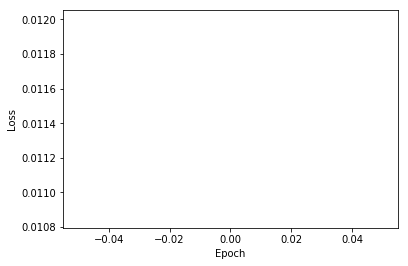

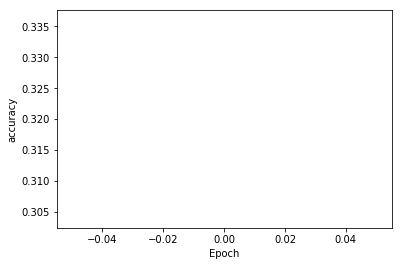

In [11]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms[x]) for x in ['train', 'val']}
print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                         shuffle=True, num_workers=3) for x in ['train', 'val']}
print("Hello")
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("Using CrossEntropyLoss")
criterion = nn.CrossEntropyLoss()

print("Using small learning rate with momentum")
optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())), lr=0.001, momentum=0.9)

print("Creating Learning rate scheduler")
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print("Training the model begun")
# model_conv = model_conv.cuda()
l = array.array('f',[])
e = array.array('f',[])
a = array.array('f',[])
model_ft = train_model(model_conv, dataloaders, dataset_sizes, criterion, optimizer_conv, exp_lr_scheduler, False,
                     num_epochs=epochs)
plt.plot(e,l)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.plot(e,a)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

In [53]:
torch.save(model_conv, 'model.pt')
